### Q-обучение с оптимизированной ε-жадной стратегией для среды "Маятник"

In [1]:
#import warnings
#warnings.simplefilter('ignore')
import numpy as np
import gym
import time
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


def show(rendered):
    clear_output(wait=True)
    plt.imshow(rendered)
    plt.show()

In [2]:
np.array([1, 2, 3]).shape

(3,)

### [Инициализация среды](https://www.gymlibrary.dev/environments/classic_control/pendulum/)

In [3]:
environment = gym.make("Pendulum-v1", g=9.81, render_mode="rgb_array")

### Определение параметров дискретизации

In [4]:
bins = {
    "x": 16,
    "y": 16,
    "angular_velocity": 16,
    "torque": 16
}
observation_space_dimensions = len(environment.observation_space.low)
lower_bounds = list()
upper_bounds = list()

for i in range(observation_space_dimensions + 1):
    if i < observation_space_dimensions:
        lower_bounds.append(environment.observation_space.low[i])
        upper_bounds.append(environment.observation_space.high[i])
    else:
        lower_bounds.append(-2)
        upper_bounds.append(2)
        
discretizer = KBinsDiscretizer(
    n_bins=list(bins.values()), encode="ordinal", strategy="uniform"
).fit([lower_bounds, upper_bounds])


def discretize(x, y, angular_velocity, torque, engine=discretizer):
    return tuple(map(int, engine.transform([[x, y, angular_velocity, torque]])[0]))


def inverse_discretize(x, y, angular_velocity, torque, engine=discretizer):
    return tuple(engine.inverse_transform([[x, y, angular_velocity, torque]])[0])

### Q-таблица из дискретных состояний среды и возможных действий

#### Выбор действия по ε-жадной стратегии и обновление Q-таблицы

In [5]:
def select_action(env, state, q_tbl, eps=0.1):
    if np.random.random() < eps:
        # исследование - выбрать случайное действие
        return discretize(0, 0, 0, env.action_space.sample()[0])[3]
    
    # эксплуатация - выбрать оптимальное действие по Q-таблице    
    return inverse_discretize(0, 0, 0, np.argmax(q_tbl[state]))[3]


def update_q_table(q_tbl, current_state, new_state, reward, action, lr=0.8):
    action_selector = discretize(0, 0, 0, action)[3]
    q_tbl[current_state][
        action_selector
    ] = (1 - lr) * q_tbl[current_state][action_selector] + lr * (reward + np.max(q_tbl[new_state]))

#### Обучение по оптимизированной ε-жадной стратегии

In [6]:
%%time
n_episodes = 100000
q_table = np.zeros(list(bins.values()))
eps = 0.1
lr = 0.8
for episode_number in range(n_episodes):    
    current_state, terminated, truncated = discretize(*environment.reset()[0], 0)[0:3], False, False
    while not terminated and not truncated:
        action = select_action(environment, current_state, q_table, eps)
        new_observation, reward, terminated, truncated, info = environment.step((action,))
        new_state = discretize(*new_observation, 0)[0:3]
        update_q_table(q_table, current_state, new_state, reward, action, lr)
        current_state = new_state
    lr *= 0.9999
    eps *= 0.9999

CPU times: total: 1h 46min 37s
Wall time: 1h 46min 39s


In [7]:
print(eps, lr)

4.53772339590113e-06 3.630178716720904e-05


### Проверка обученного агента

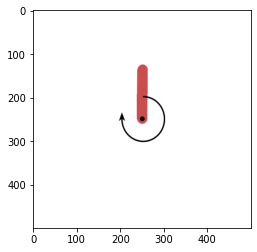

In [8]:
eps = 0
current_state, terminated, truncated = discretize(*environment.reset()[0], 0)[0:3], False, False
while not terminated and not truncated:
    action = select_action(environment, current_state, q_table, eps)
    new_observation, reward, terminated, truncated, info = environment.step((action,))
    current_state = discretize(*new_observation, 0)[0:3]
    show(environment.render())
    time.sleep(0.05)
environment.close()